## 1. Installation and imports

In [112]:
!pip install google-cloud-storage
!pip install MedPy
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# change working directory
# NOTE: this path will probably differ for each person 
# option 1: either make everyone create the same folder path so this does not need to be changed everytime where running a notebook
# option 2: create a local environment file .env file to store individual configurations for each person (this will be in the .gitignore)
working_dir = '/content/drive/My Drive/Capstone Project/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [196]:
import importlib
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import medpy.metric.binary as mdp
import numpy as np
import os
import seg_metrics.seg_metrics as sg

from scipy.ndimage import distance_transform_edt, binary_erosion, generate_binary_structure
from scipy.ndimage import _ni_support

# Custom modules
# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates

import utils.mri_images as mri
import utils.mri_plotter as mrp

importlib.reload(mri)
importlib.reload(mrp)

from utils.mri_images import MriImage
from utils.mri_plotter import MRIPlotter

In [126]:
# Get segmented and auto segmented files
mri_img = MriImage()

segm_files = mri_img.list_blobs_in_folder(segm=True)
auto_segm_files = mri_img.list_blobs_in_folder(auto_segm=True)
print("No. of segmented files:", len(segm_files))
print("No. of auto-segmented files:", len(auto_segm_files))

No. of segmented files: 147
No. of auto-segmented files: 611


### Data Functions

In [93]:
# Source Code: https://github.com/loli/medpy/blob/master/medpy/metric/binary.py#L357
def calc_surface_distances(pred_img_bin, true_img_bin, voxelspacing=None, connectivity=1):
  """
  The distances between the surface voxel of binary objects in result and their
  nearest partner surface voxel of a binary object in reference.
  """
  if voxelspacing is not None:
      # ensures that the sequence has the same length as the number of dimensions in the result array
      # not needed for now
      voxelspacing = _ni_support._normalize_sequence(voxelspacing, pred_img_bin.ndim)
      voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
      if not voxelspacing.flags.contiguous:
          voxelspacing = voxelspacing.copy()
          
  # this will create 3x3 binary array with False values at the center
  # and its surrounding structures. diagonals are not considered if connectivity = 1
  footprint = generate_binary_structure(pred_img_bin.ndim, connectivity)

  # extract only 1-pixel border line of objects
  # applies binary erosion to the image
  pred_img_border = pred_img_bin ^ binary_erosion(pred_img_bin, structure=footprint, iterations=1)
  true_img_border = true_img_bin ^ binary_erosion(true_img_bin, structure=footprint, iterations=1)

  # calculate distances from each voxel to the closest border 
  dist = distance_transform_edt(~true_img_border, sampling=voxelspacing)
  surface_dist = np.where(pred_img_border, dist, None)
  return surface_dist

def exec_hausdorff_95(pred_img, true_img, segment, plot=False):
  # convert image to binary
  true_img_bin = (true_img == segment)
  pred_img_bin = (pred_img == segment)

  if np.sum(true_img_bin) + np.sum(pred_img_bin) == 0:
    raise Exception("Images do not have common segments")

  connectivity = pred_img_bin.ndim * 2
  sd1 = calc_surface_distances(pred_img_bin, true_img_bin, connectivity=connectivity)
  sd2 = calc_surface_distances(true_img_bin, pred_img_bin, connectivity=connectivity)
  sd1_no_none = sd1[sd1 != None]
  sd2_no_none = sd2[sd2 != None]
  hd95_val = np.percentile(np.hstack((sd1_no_none, sd2_no_none)), 95)
  
  if plot:
    return [hd95_val, sd1, sd2]
  else:
    return hd95_val
  
def calc_hausdorff_95(pred_img, true_img, segment):
    return exec_hausdorff_95(pred_img, true_img, segment, plot=False)

def plot_hausdorff_95(pred_img, true_img, segment):
    return exec_hausdorff_95(pred_img, true_img, segment, plot=True)

def calc_dice_score(pred_img, true_img, segment):
    # metric in medical image segmentation to evaluate similarity or overlap between segmented images
    # convert images to binary
    true_img_bin = (true_img == segment)
    pred_img_bin = (pred_img == segment)

    # perform element wise multiplication to get intersection
    intersection = np.sum(pred_img_bin * true_img_bin)
    dice_score = (2.0 * intersection) / (np.sum(true_img_bin) + np.sum(pred_img_bin))
    return dice_score

def calc_metric_all_segments(segments, metric_func, *args, **kwargs):
    values = Parallel(n_jobs=-1)(delayed(metric_func)(*args, **kwargs, segment=segment) for segment in segments)
    return np.array(values)

### Metrics

In [236]:
all_dice = []
all_hd95 = []
all_missclass_per_label = []
all_true_per_label = []
error_files = []

In [238]:
# Calculate dice score one by one for each image to avoid out-of-memory issues
subj_files = [segm_file.split("_segm")[0] for segm_file in segm_files]
for subj_file in subj_files:

  # load the segmented and auto segmented image of a file
  segm_img = mri_img.read(subj_file, segm=True)[1]
  auto_segm_img = mri_img.read(subj_file, auto_segm=True)[1]

  try:
      print(f"Calculating metrics for {subj_file}")
      # metric 1: just count incorrect labels vs true labels for each file
      misclassified_per_label = []
      true_per_label = []
      for segment in mri.SEGMENTS:
        true_count = np.sum(segm_img == segment)
        pred_count = np.sum(auto_segm_img == segment)

        count_difference = abs(true_count - pred_count)

        true_per_label.append(true_count)
        misclassified_per_label.append(count_difference)

      # metric 2: dice coefficient
      dice_score = calc_metric_all_segments(mri.SEGMENTS, calc_dice_score, auto_segm_img, segm_img)

      # metric 3: 95% Hausdorff
      hausdorff_val =  calc_metric_all_segments(mri.SEGMENTS, calc_hausdorff_95, auto_segm_img, segm_img)
  
      # append only when there is no error:
      all_dice.append(dice_score)
      all_hd95.append(hausdorff_val)
      all_missclass_per_label.append(misclassified_per_label)
      all_true_per_label.append(true_per_label)
  except Exception as ex:
      print(f"Error {subj_file}", ex)
      error_files.append(subj_file)

Calculating metrics for UPENN-GBM-00002_11
Calculating metrics for UPENN-GBM-00006_11
Calculating metrics for UPENN-GBM-00008_11
Calculating metrics for UPENN-GBM-00009_11
Calculating metrics for UPENN-GBM-00011_11
Calculating metrics for UPENN-GBM-00013_11
Calculating metrics for UPENN-GBM-00014_11
Calculating metrics for UPENN-GBM-00016_11
Calculating metrics for UPENN-GBM-00017_11
Calculating metrics for UPENN-GBM-00018_11
Calculating metrics for UPENN-GBM-00020_11
Calculating metrics for UPENN-GBM-00021_11
Calculating metrics for UPENN-GBM-00026_11
Calculating metrics for UPENN-GBM-00029_11
Calculating metrics for UPENN-GBM-00030_11
Calculating metrics for UPENN-GBM-00031_11
Calculating metrics for UPENN-GBM-00033_11
Calculating metrics for UPENN-GBM-00035_11
Calculating metrics for UPENN-GBM-00040_11
Calculating metrics for UPENN-GBM-00041_11
Calculating metrics for UPENN-GBM-00043_11
Calculating metrics for UPENN-GBM-00054_11
Calculating metrics for UPENN-GBM-00059_11
Calculating

### COUNT DIFFERENCE/ TRUE COUNT

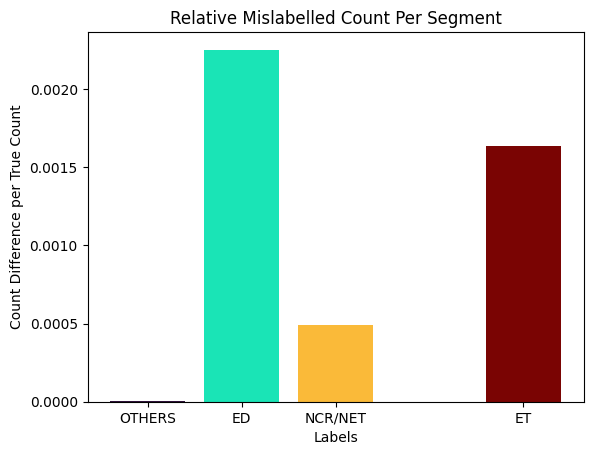

In [242]:
# TODO: maybe get percentage
# Plot mislabelled counts
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

total_misclassifed = np.array(misclassified_per_label).sum(axis = 0)
true_count = np.array(all_true_per_label).sum(axis = 0)
plt.bar(mri.SEGMENTS, total_misclassifed/true_count, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count Difference per True Count')
plt.title('Relative Mislabelled Count Per Segment')
plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

### DICE SCORE PER SEGMENT

ED has the lowest (LABEL 1)

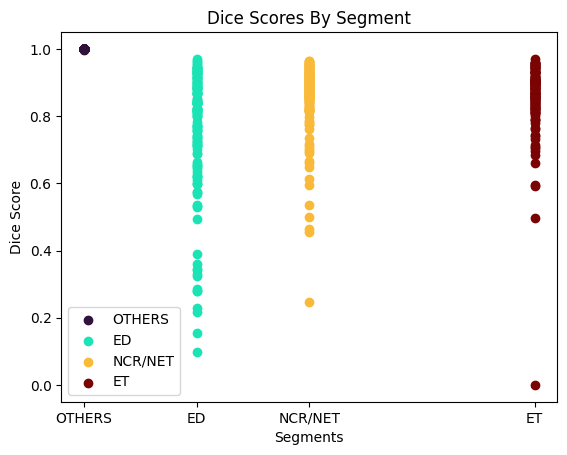

In [217]:
# Plot the dice scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

for idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_dice)[:, idx]
  label = mri.SEGMENTS[idx]
  x_val = [label] * len(dice_scores)

  plt.scatter(x_val, dice_scores, label=f"{mri.SEGMENT_NAMES[idx]}", color=colors[idx])
  plt.xlabel('Segments')
  plt.ylabel('Dice Score')
  plt.title('Dice Scores By Segment')
  plt.legend()

plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

### DICE SCORE FOR EACH FILE

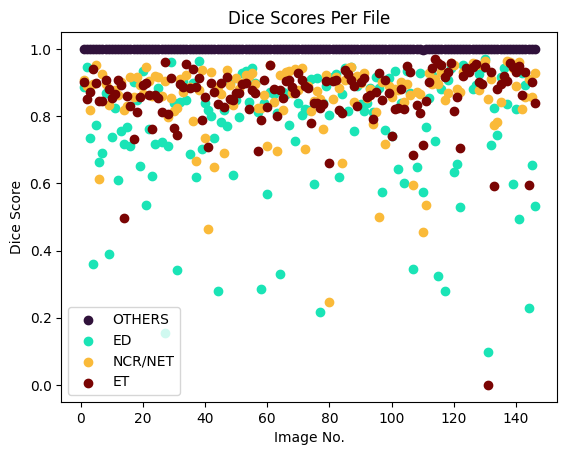

In [247]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

scores_len = len(all_dice)

for segm_idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_dice)[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx], label=f"{mri.SEGMENT_NAMES[segm_idx]}")

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

### PLOT IMAGES WITH THE LOWEST DICE SCORES

In [263]:
# Get 10 images with lowest dice scores
all_dice_np = np.array(all_dice)

# Flatten the array
flattened_array = all_dice_np.flatten()

# Find the indices of the top 10 smallest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=10)[:10]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_dice_np.shape)

# remove error files from subj_files
print("errors", error_files)
subj_files = list(filter(lambda x: x not in error_files, subj_files))
print(f"New length after removing problematic images: {len(subj_files)}")

subj_files_np = np.array(subj_files)
lowest_dice_images = subj_files_np[list(top_10_indices[0])]

In [214]:
def get_nonzero_extents(arr):
  if not np.any(arr != 0):
    center = np.array(arr.shape) // 2
    minima = center - 1
    maxima = center + 1
    return minima, maxima
  else:
    indices = np.where(arr != 0)
    minima = np.min(indices, axis=1)
    maxima = np.max(indices, axis=1)
    return minima, maxima

def get_bounds(true_img_bin, pred_img_bin):
  min1, max1 = get_nonzero_extents(true_img_bin)
  min2, max2 = get_nonzero_extents(pred_img_bin)
  combined_min = np.minimum(min1, min2)
  combined_max = np.maximum(max1, max2)

  adj_min = np.maximum(combined_min-10, 0)
  adj_max = np.minimum(combined_max+10, np.array(true_img_bin.shape) - 1)
  return adj_min, adj_max

def slice_image(img, adj_min, adj_max):
  return img[adj_min[0]:adj_max[0]+1, 
             adj_min[1]:adj_max[1]+1,
             :]

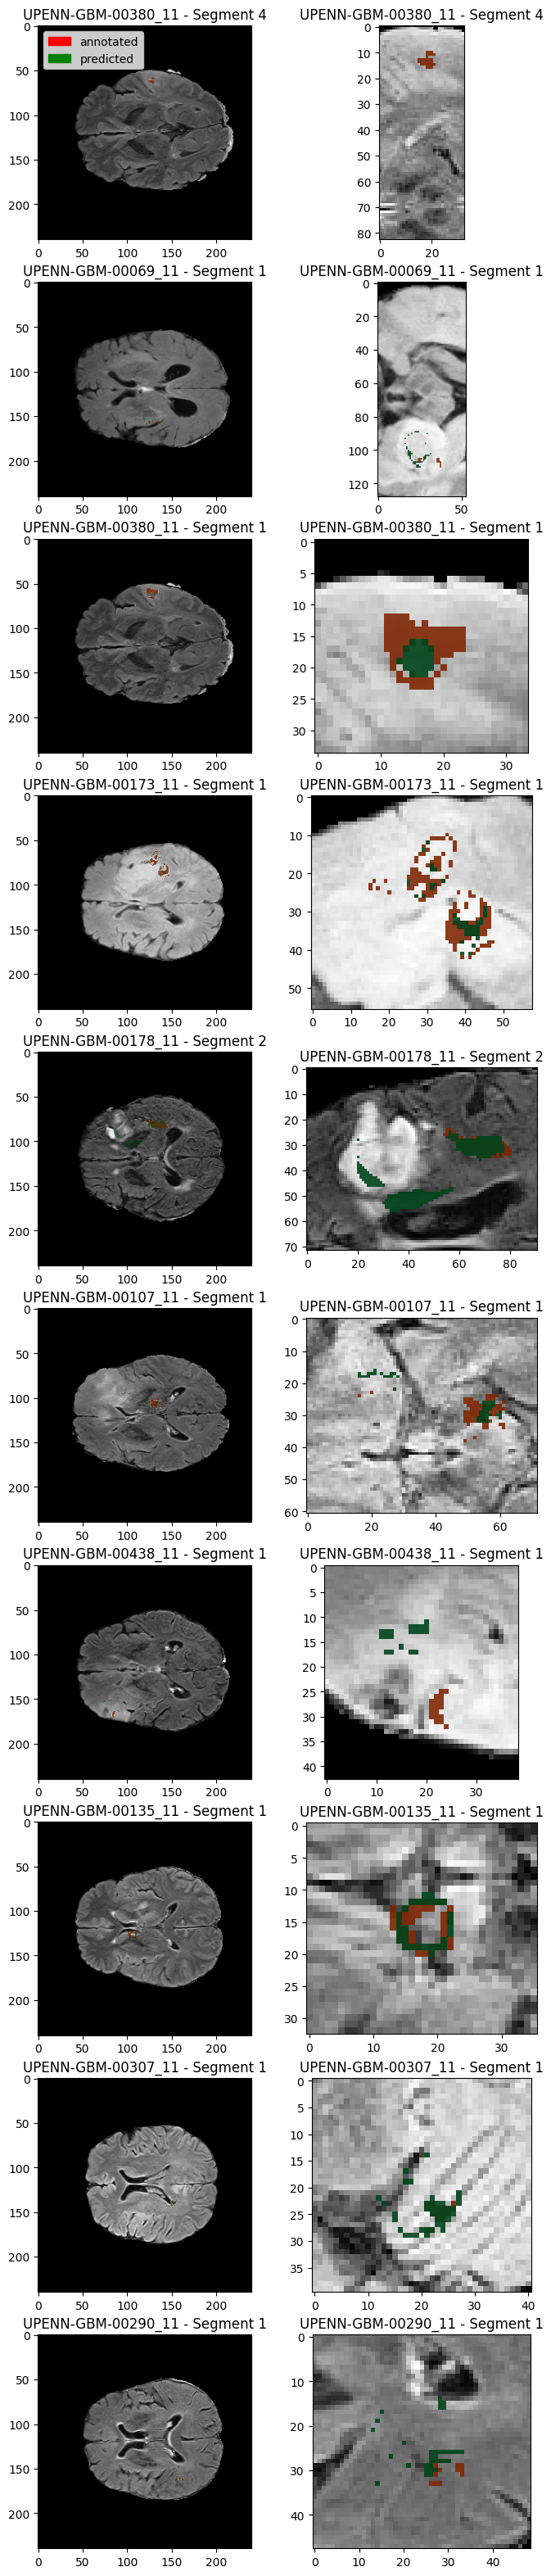

In [264]:
mri_plt = MRIPlotter()
nrows=10
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

row, col = 0, 0
for idx, subj_file in enumerate(lowest_dice_images):
  # add legend
  orange = mpatches.Patch(color='red', label='annotated')
  green = mpatches.Patch(color='green', label='predicted')
  axs[row, col].legend(handles=[orange, green], loc='upper left')

  # plot base image FLAIR
  base_img = mri_img.read(subj_file=subj_file, struct_scan="FLAIR")[1]

  # plot segments with lowest dice scores
  true_img = mri_img.read(subj_file=subj_file, segm=True)[1]
  pred_img = mri_img.read(subj_file=subj_file, auto_segm=True)[1]

  # get binary images for segment in question
  segment = mri.SEGMENTS[top_10_indices[1][idx]]
  true_img_bin = (true_img == segment)
  pred_img_bin = (pred_img == segment)
  
  # plot full mri scan
  mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_img_bin, fig=fig, axs=axs, row=idx, col=0, 
                        segm_cbar=False, overlay=True, cmap='Oranges', 
                        alpha = np.where(true_img_bin == 0, 0, 0.8))
  mri_plt.plot_segm_img(img_data=pred_img_bin, fig=fig, axs=axs, row=idx, col=0, 
                        segm_cbar=False, overlay=True, cmap="Greens")

  # plot zoomed view
  adj_min, adj_max = get_bounds(true_img_bin, pred_img_bin)
  base_sliced = slice_image(base_img.copy(), adj_min, adj_max)
  true_sliced = slice_image(true_img_bin.copy(), adj_min, adj_max)
  pred_sliced = slice_image(pred_img_bin.copy(), adj_min, adj_max)
  
  mri_plt.plot_struct_img(img_data=base_sliced, fig=fig, axs=axs, row=idx, col=1, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_sliced, fig=fig, axs=axs, row=idx, col=1, 
                        segm_cbar=False, overlay=True, cmap='Oranges',
                        alpha=np.where(true_sliced == 0, 0, 0.9))
  mri_plt.plot_segm_img(img_data=pred_sliced, fig=fig, axs=axs, row=idx, col=1, 
                        segm_cbar=False, overlay=True, cmap="Greens",
                        alpha=np.where(pred_sliced == 0, 0, 0.9))
plt.show()

### HAUSDORFF DISTANCES PER SEGMENT

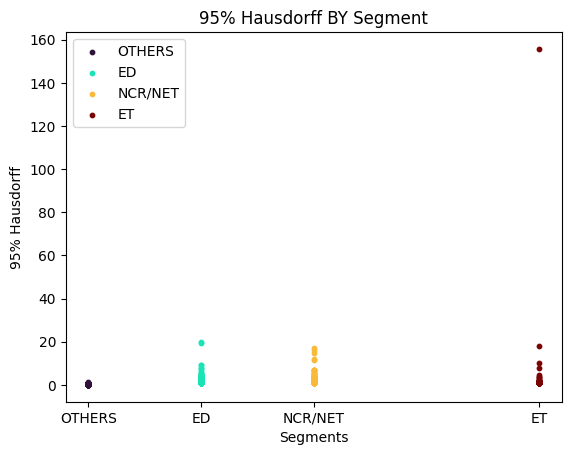

In [256]:
# Plot hausdorff scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

for idx in range(len(mri.SEGMENTS)):
  y_val = np.array(all_hd95)[:, idx]
  label = mri.SEGMENTS[idx]
  x_val = [label] * len(y_val)

  plt.scatter(x_val, y_val, label=f"{mri.SEGMENT_NAMES[idx]}", color=colors[idx], s=10)
  plt.xlabel('Segments')
  plt.ylabel('95% Hausdorff')
  plt.title('95% Hausdorff BY Segment')
  plt.legend()

plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

### HAUSDORFF DISTANCES PER FILE

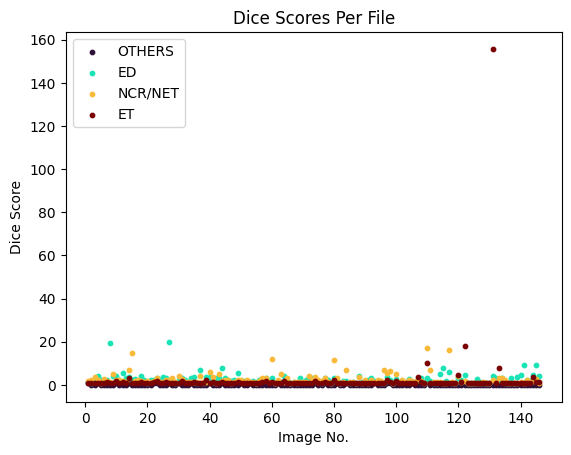

In [253]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

scores_len = len(all_hd95)

for segm_idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_hd95)[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx],
              label=f"{mri.SEGMENT_NAMES[segm_idx]}", s=10)

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

### PLOT IMAGES WITH HIGHEST HD95 SCORE

In [276]:
# Get 10 images with lowest dice scores
all_hd95_np = np.array(all_hd95)

# Flatten the array
flattened_array = all_hd95_np.flatten()

# Find the indices of the top 10 largest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=-10)[-10:]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_hd95_np.shape)

subj_files_np = np.array(subj_files)
highest_hd95_val = subj_files_np[list(top_10_indices[0])]

In [ ]:
# plot_hausdorff_95(pred_img, true_img, segment)

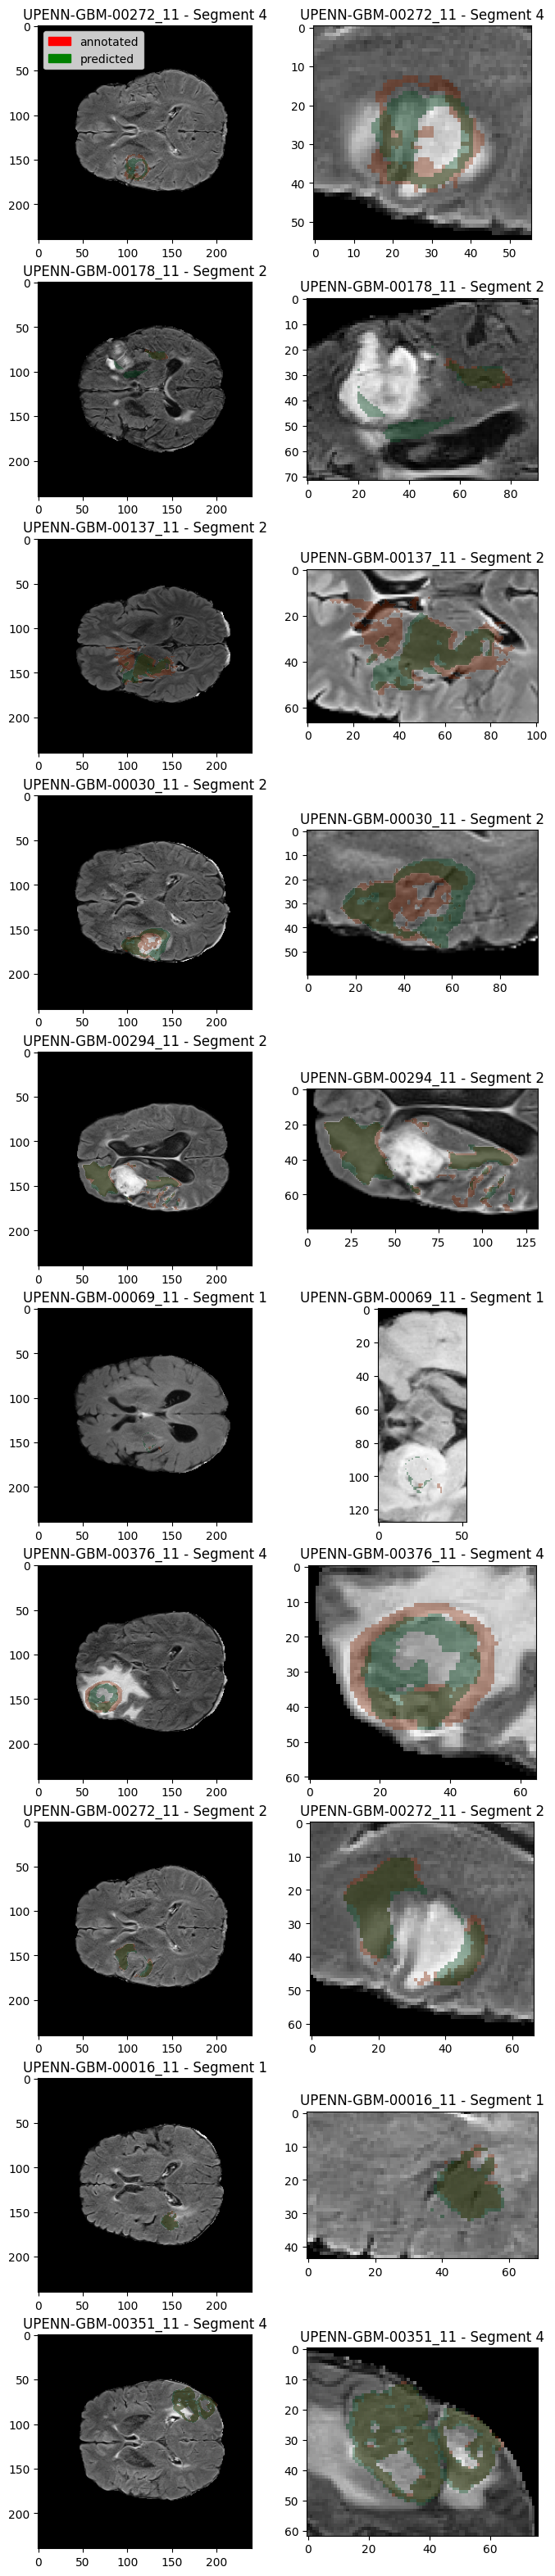

In [278]:
nrows=10
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

row, col = 0, 0
for idx, subj_file in enumerate(highest_hd95_val):

  # plot only the specific segment with the lowest dice coeff
  orange = mpatches.Patch(color='red', label='annotated')
  green = mpatches.Patch(color='green', label='predicted')
  axs[row, col].legend(handles=[orange, green], loc='upper left')

  # plot base image FLAIR
  base_img = mri_img.read(subj_file=subj_file, struct_scan="FLAIR")[1]

  # plot segments with lowest dice scores
  true_img = mri_img.read(subj_file=subj_file, segm=True)[1]
  pred_img = mri_img.read(subj_file=subj_file, auto_segm=True)[1]


  # get binary images for segment in question
  segment = mri.SEGMENTS[top_10_indices[1][idx]]
  true_img_bin = (true_img == segment)
  pred_img_bin = (pred_img == segment)
  
  # plot full mri scan
  mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_img_bin, fig=fig, axs=axs, row=idx, col=0, 
                        segm_cbar=False, overlay=True, cmap='Oranges')
  mri_plt.plot_segm_img(img_data=pred_img_bin, fig=fig, axs=axs, row=idx, col=0, 
                        segm_cbar=False, overlay=True, cmap="Greens")

  # plot zoomed view
  adj_min, adj_max = get_bounds(true_img_bin, pred_img_bin)
  base_sliced = slice_image(base_img.copy(), adj_min, adj_max)
  true_sliced = slice_image(true_img_bin.copy(), adj_min, adj_max)
  pred_sliced = slice_image(pred_img_bin.copy(), adj_min, adj_max)
  
  mri_plt.plot_struct_img(img_data=base_sliced, fig=fig, axs=axs, row=idx, col=1, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_sliced, fig=fig, axs=axs, row=idx, col=1, 
                        segm_cbar=False, overlay=True, cmap='Oranges')
  mri_plt.plot_segm_img(img_data=pred_sliced, fig=fig, axs=axs, row=idx, col=1, 
                        segm_cbar=False, overlay=True, cmap="Greens")
plt.show()